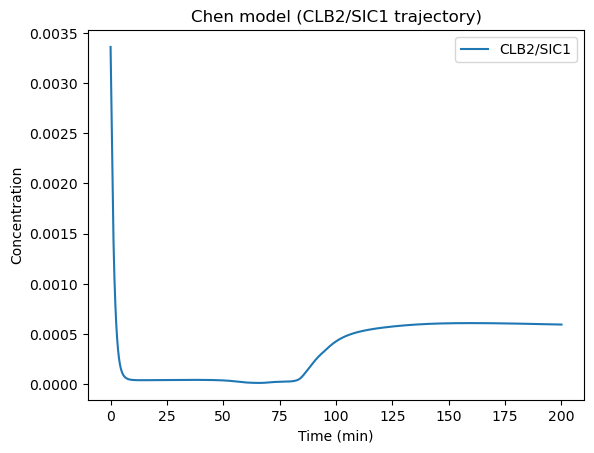

Up-Down encoding: 0001111000000111111111111111111100000000 ...


KeyboardInterrupt: 

In [10]:
import tellurium as te
import numpy as np
import matplotlib.pyplot as plt
import random

import roadrunner

# Silence RoadRunner log messages completely
roadrunner.Logger.setLevel(roadrunner.Logger.LOG_CRITICAL)


# Load Chen 2004 budding yeast cell cycle model
rr = te.loadSBMLModel("chen2004_biomd56.xml")
multipliers = [0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 2.00]

def sample_parameters(rr):
    """Multiply only free global parameters by a random factor.
       Report how many were perturbed vs. skipped (assignment/algebraic rules)."""
    sampled = {}
    skipped = []
    for pid in rr.getGlobalParameterIds():
        try:
            current = rr.getValue(pid)   # may fail if pid is assignment-ruled
            factor = random.choice(multipliers)
            rr.setValue(pid, current * factor)
            sampled[pid] = factor
        except RuntimeError:
            skipped.append(pid)
            continue

def simulate_and_extract(rr, tmax=200, npoints=2001):
    rr.selections = ["time"] + rr.getFloatingSpeciesIds()
    try:
        result = rr.simulate(0, tmax, npoints)
    except RuntimeError as e:
        # Any CVODE failure: return None

        return None, None
    
    time = result[:, 0]
    cols = rr.selections

    clb2 = result[:, cols.index("CLB2")]
    sic1 = result[:, cols.index("SIC1")]
    signal = clb2 * sic1
    return time, signal


def up_down_encoding(time, signal, delta_t=5.0):
    """Binary string of slope signs at intervals of delta_t."""
    bits = []
    sample_times = np.arange(time[0], time[-1], delta_t)
    for t in sample_times:
        val_now = np.interp(t, time, signal)
        val_next = np.interp(t + delta_t, time, signal)
        slope = val_next - val_now
        bits.append("1" if slope >= 0 else "0")
    return "".join(bits)

# Reset to wild-type before sampling
rr.reset()

# Sample new parameter set
params = sample_parameters(rr)

# Simulate with perturbed parameters
time, clb2_sic1 = simulate_and_extract(rr)

# Encode oscillations
encoding = up_down_encoding(time, clb2_sic1, delta_t=5.0)

# Plot trajectory
plt.plot(time, clb2_sic1, label="CLB2/SIC1")
plt.xlabel("Time (min)")
plt.ylabel("Concentration")
plt.title("Chen model (CLB2/SIC1 trajectory)")
plt.legend()
plt.show()

print("Up-Down encoding:", encoding[:120], "...")

# Number of samples (use small first, scale up later)
N = 10000  # try 1e4 first, then go bigger in batches


encodings = []
skipped_count = 0

for i in range(N):
    rr.reset()
    sample_parameters(rr)
    time, clb2_sic1 = simulate_and_extract(rr)

    if time is None:   # failed integration
        skipped_count += 1
        continue

    encoding = up_down_encoding(time, clb2_sic1, delta_t=5.0)
    encodings.append(encoding)

    if (i+1) % 1000 == 0:
        print(f"Completed {i+1} samples | successful: {len(encodings)} | skipped: {skipped_count}")

print(f"\nFinal results: {len(encodings)} successful, {skipped_count} skipped")



